Found 84 skymap files
Processed 10/84 files
Processed 20/84 files
Processed 30/84 files
Processed 40/84 files
Processed 50/84 files
Processed 60/84 files
Processed 70/84 files
Processed 80/84 files


OSError: [Errno 30] Read-only file system: 'GW_synthetic_skymap.png.npy'

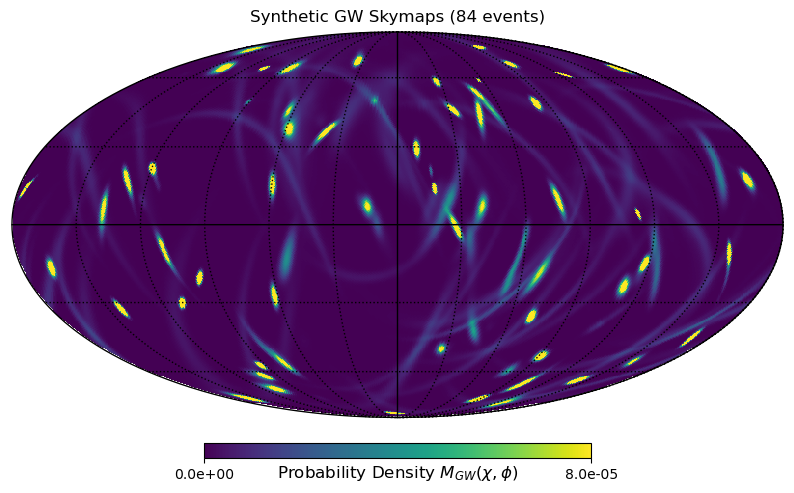

In [ ]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from ligo.skymap.io.fits import read_sky_map
import glob
import re

skymap_files = []

# Define the base path
#base_path = "/Users/leo/Library/CloudStorage/Dropbox/gw.phy.cuhk.edu.hk/static/simulated_skymaps"

base_path = '/Users/leo/Library/CloudStorage/Dropbox/gw.phy.cuhk.edu.hk/static/simulated_skymaps/test_set'

# Define the set ranges - you can adjust these as needed
'''set_ranges = [
    "sets_1_100",
    "sets_101_200",
    "sets_201_300",
    "sets_301_400",
    "sets_401_500",
    "sets_501_600",
    "sets_601_700",
    "sets_701_800",
    "sets_801_900",
    "sets_901_1000",
    
]'''

# For each set range, loop through set folders
#for set_range in set_ranges:
for set_num in range(1, 4):  # set_0 to set_99
    pattern = f"{base_path}/set_{set_num}/*.fits.gz"
    skymap_files.extend(glob.glob(pattern))

# Get all .fits files in directory

if not skymap_files:
    print(f"No .fits files found")
    
print(f"Found {len(skymap_files)} skymap files")
    
NSIDE = 128 
NPIX = hp.nside2npix(NSIDE)
    
    # Define the combined (added) skymap
combined_map = np.zeros(NPIX)
    
    # Process the skymaps
for i, fits_file in enumerate(skymap_files):
    try:
        # Read skymap
        skymap, header = read_sky_map(fits_file, nest=False, distances=False, moc=False)
            
        # Resample to common resolution(important with power=-2)
        skymap_resized = hp.ud_grade(skymap, NSIDE, pess=False, order_in='RING', order_out='RING', power=-2, dtype=None)
        
        # Add to combined map
        combined_map += skymap_resized / np.sum(skymap_resized)  # Normalize each map before adding, so that each contributes equally
            
        if (i+1) % 10 == 0:
            print(f"Processed {i+1}/{len(skymap_files)} files")
                
    except Exception as e:
        print(f"Error reading {fits_file}: {e}")
        continue
    

combined_map = combined_map / np.sum(combined_map)  # Normalize combined map

    
# Plot the combined skymap
plt.figure(figsize=(10, 6))
    
hp.mollview(
    combined_map,
    title=f"Synthetic GW Skymaps ({len(skymap_files)} events)",
    min=0,
    max=np.percentile(combined_map[combined_map > 0], 99),
    cbar=True,
    cmap='viridis',
    format='%.1e',
    unit="Probability Density $M_{GW}(\chi,\phi)$", 
    hold=True
    )
    
hp.graticule()
